# Probabilistic classification

Binary classification tasks allow just two possible outcomes per prediction. That result often obscures additional context that is available from the classifier.

For example, $k$ nearest neighbors reports the winner of the majority of votes among the $k$ examples closest to the query point. But we should probably be more skeptical about a query that wins, say, by a 4--3 vote as opposed to 7--0. To give a more nuanced picture, we could report the fraction of votes cast for the positive label. Then there are $k+1$ possible values equally spaced between 0 and 1. In the case of a decision tree, each query eventually ends up at a leaf of sample points, and we can report the fraction of samples that have the positive label.

It's easy to interpret such a result as predicting the *probability* of the positive label at any query point. Conceptually this is more akin to regression than classification, because learner outputs values between 0 and 1, even though the data are all presented with labels from the set $\{0,1\}$. 

Consider the penguin species classification problem.

In [1]:
import seaborn as sns
penguins = sns.load_dataset("penguins").dropna()
# Select only numeric columns for features:
X = penguins.loc[:,penguins.dtypes=="float64"]  
y = penguins["species"].astype("category")

from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=5)

We can use $k=5$ on a nearest neighbors classifier, and use it to predict species as we have before.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr,y_tr)
knn.predict(X_te.iloc[:6,:])

array(['Adelie', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie'],
      dtype=object)

But we can also access the probabilistic interpretation via `predict_proba`.

In [3]:
p_hat = knn.predict_proba(X_te)
p_hat[:6,:]

array([[0.8, 0.2, 0. ],
       [0.8, 0.2, 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0.8, 0.2, 0. ],
       [0.6, 0.4, 0. ]])

From the output above we see that, for example, while the third and fourth test cases led to unanimous votes for *Gentoo*, the sixth case was deemed *Adelie* in a 3--2 squeaker (or is it squawker?).

## ROC curve

The **ROC curve**, or *receiver operator characteristic* curve, is a way to play what-if by adjusting the voting margins needed to "win" a positive label. Let's explain by continuing the penguin example with $k=5$. 

Say that at some query point, there are 2 votes for A, 2 for C, and 1 for G. We might flip a coin and decide on class A, but from a one-versus-rest (OVR) point of view, it would be reasonable to say that A failed to win 50% of the votes. In fact, at that level, *none* of the species should be considered having received a "positive" vote. 

We can apply this idea with an adjustable threshold $\theta$ in the interval $[0,1]$. If a single class receives a fraction of votes that is at least $\theta$, it has a positive result for that class. This means that we no longer assign a label "A/C/G" to each query, but a vector $[A,C,G]$ in which each component is either 0 or 1. Specifically, each vote fraction that is less than $\theta$ is rounded down, and the others are rounded up. 

For instance, at $\theta=0$, every query is labeled $[1,1,1]$. For $\theta > 0$, any class receiving no votes at a query point gets a negative result, i.e., 0 in its component. For $\theta > 0.2$, any class getting zero or one vote (out of $k=5$ total) is a negative result, and so on. When $\theta=1$, only a class receiving a unanimous vote is scored as positive, and if we imagine $\theta > 1$, then the result at any query point is $[0,0,0]$, because nothing can receive more than 100% of the votes!

In the code, we can set a threshold value and easily determine the positive-result vector at each of the test points:

In [4]:
def hits(p_hat,theta):
    return (p_hat >= theta).astype(int)

pos = hits(p_hat,2/3)
print(pos[:6,:])

[[1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 0]]


We should compare the first column of the `pos` matrix, for the *Adelie* species, to the test cases actually labelled *Adelie* to find all the true positives:

In [5]:
A_actual = (y_te=="Adelie").astype(int)
A_truepos = pos[:,0]*A_actual

Similarly, we can find all the false positives for *Adelie* as well:

In [6]:
A_falsepos = pos[:,0]*(1-A_actual)

It makes sense to reason about the rate of true positives, the fraction of actual positive cases identified as such, and the rate of false positives, the fraction of actual negative cases mistakenly identified as positive:

In [7]:
A_TPrate = sum(A_truepos) / sum(A_actual)
A_FPrate = sum(A_falsepos) / sum(1-A_actual)
print(f"TP rate: {A_TPrate:.4f}, FP rate: {A_FPrate:.4f}")

TP rate: 0.5667, FP rate: 0.0541


As a matter of fact, the TP rate is just the recall, and the FP rate is 1 minus the specificity. We can repeat this calculation over all values of the threshold between 0 and 1. We don't have to, though, because there is a function in sklearn for it already.

In [8]:
from sklearn.metrics import roc_curve
fp_rate,tp_rate,theta = roc_curve(y_te=="Adelie",p_hat[:,0])

import pandas as pd
pd.DataFrame({"TP rate":tp_rate,"FP rate":fp_rate,"threshold":theta})

,TP rate,FP rate,threshold
0,0.000000,0.000000,2.0
1,0.233333,0.027027,1.0
2,0.566667,0.054054,0.8
3,0.900000,0.216216,0.6
4,0.966667,0.405405,0.4
5,1.000000,0.459459,0.2
6,1.000000,1.000000,0.0


The table above only records the values of $\theta$ where the rates change. Usually, this information is presented in graphical form as an **ROC curve**. We can make one for each species as follows.

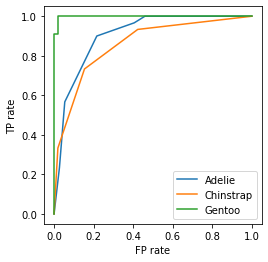

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig,ax = plt.subplots()
for i,label in enumerate(knn.classes_):
    RocCurveDisplay.from_predictions(y_te==label,p_hat[:,i],ax=ax)

ax.set_xlabel("FP rate")
ax.set_ylabel("TP rate")
ax.set_aspect(1)
ax.legend(knn.classes_);

The ideal situation is in the top left corner of the plot, corresponding to perfect recall and specificity. Each curve starts in the lower left corner and ends at the upper right corner. The *Gentoo* curve comes quite close to the ideal. All of the curves explicitly show the tradeoff between recall and specificity. The information could be used to choose a threshold that favors either side of the tradeoff.

If we weight neighbors' votes inversely to their distance from the query point, then the thresholds aren't restricted to multiples of $\tfrac{1}{5}$, and the curves have more features.

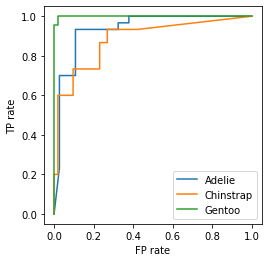

In [10]:
knnw = KNeighborsClassifier(n_neighbors=5,weights="distance")
knnw.fit(X_tr,y_tr)
p_hat = knnw.predict_proba(X_te)

fig,ax = plt.subplots()
for i,label in enumerate(knn.classes_):
    RocCurveDisplay.from_predictions(y_te==label,p_hat[:,i],ax=ax)

ax.set_xlabel("FP rate")
ax.set_ylabel("TP rate")
ax.set_aspect(1)
ax.legend(knn.classes_);

ROC curves lead to another classification performance metric known as **area under ROC curve** (AUC-ROC). Its name tells you exactly what it is, and it ranges between zero (bad) and one (ideal). Unlike the other classification metrics we have encountered, AUC-ROC tries to account not just for the final result of the classification, which nominally occurs when the threshold is $\tfrac{1}{2}$, but also for the confidence with which those results can be predicted.

The function `roc_auc_score` requires a keyword argument when there are more than two classes, to specify "one vs. rest" or "one vs. one" matchups.

In [11]:
from sklearn.metrics import roc_auc_score
s = roc_auc_score(y_te, knn.predict_proba(X_te),multi_class="ovr")
print(f"AUC for knn-uniform: {s:.4f}")

sw = roc_auc_score(y_te,knnw.predict_proba(X_te),multi_class="ovr")
print(f"AUC for knn-weights: {sw:.4f}")

AUC for knn-uniform: 0.9194
AUC for knn-weights: 0.9393


**Note about the video.** In it, I'm using an older version of the code above where I compute the data for the curves and plot them manually. You can skip over those parts without missing anything important.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_apqqbhl3&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_w2notzkt" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>